<a href="https://colab.research.google.com/github/Debora-Simoes/IA901-2023S1/blob/main/projetos/Reconhecimento_acao_humana_imagem_drone/notebooks/Dados_Balanceados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import shutil

#import matplotlib.image as mpimg
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Importando dados brutos

In [ ]:
TRAIN_DATA_DIR = "/content/gdrive/My Drive/IA901_Projeto/_Dataset_NTUT_4K_drone/ntut_drone_train/ntut_drone_train"
TEST_DATA_DIR = '/content/gdrive/My Drive/IA901_Projeto/_Dataset_NTUT_4K_drone/ntut_drone_test/ntut_drone_test'

In [ ]:
lista_de_drones = os.listdir(TRAIN_DATA_DIR)
lista_de_drones

['Drone_023', 'Drone_005', 'Drone_031', 'Drone_049']

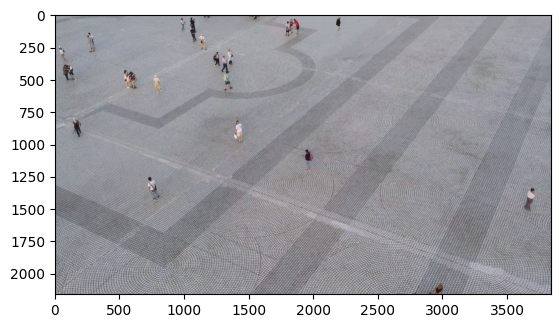

In [ ]:
# Verificando uma imagem
test_file = TRAIN_DATA_DIR + '/Drone_049/vott-csv-export/Drone_049.mp4_t-9.jpg'

img = cv2.imread(test_file)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

##Analisando dados de treino

In [ ]:
#Montar tabela com todos os dados de treino ou teste
def dataframe(DATA_DIR):
  pastas = os.listdir(DATA_DIR)

  data = []
  #count = 0
  for dir in pastas:
      export_path = os.path.join(DATA_DIR, dir, 'vott-csv-export')
      label_file = export_path + '/' + dir + '-export.csv'
      df = pd.read_csv(label_file)
      data.append(df)
  return data, pastas

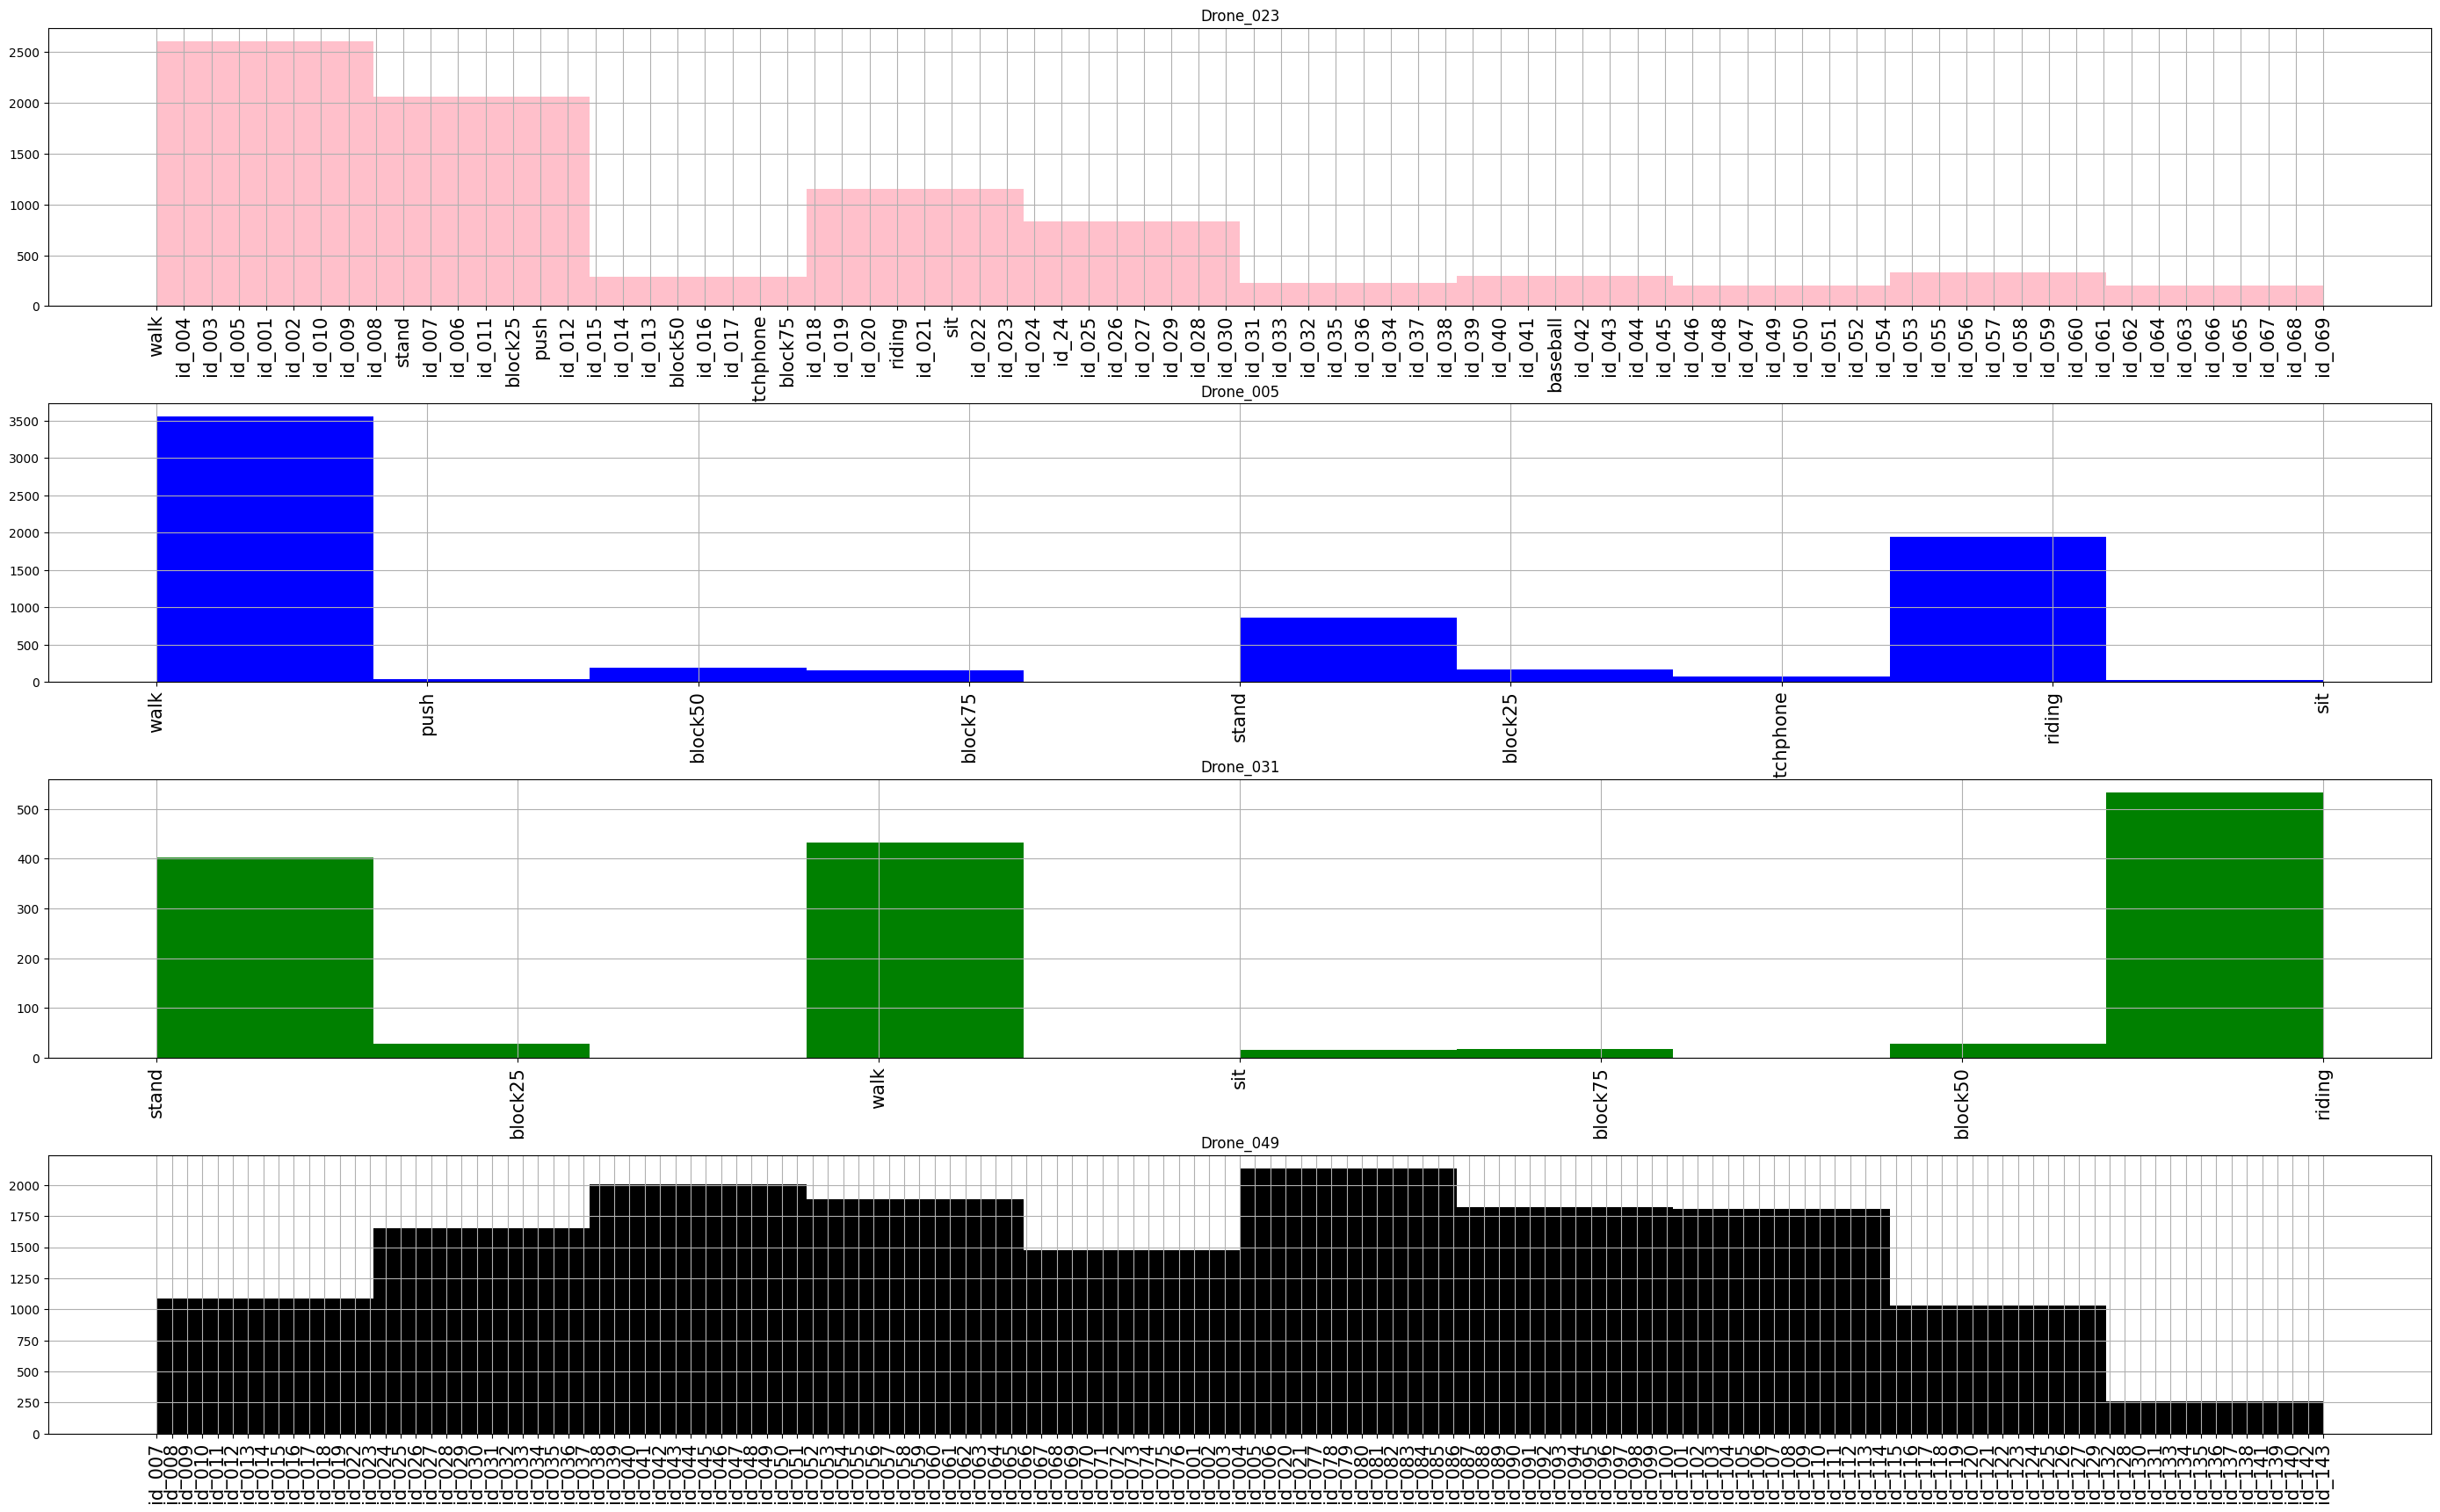

In [ ]:
data, pastas = dataframe(TRAIN_DATA_DIR)  #chama função para montar dataframe de cada pasta

#plota o histograma
figura = plt.figure(figsize=(35,20))
color = ['pink','blue','green','black']

for c in range(len(pastas)):
  a = figura.add_subplot(4,1,c+1)
  a.title.set_text(pastas[c])
  plt.hist(data[c]['label'], rwidth=1, color = color[c])
  plt.xticks(rotation=90,fontsize=15)
  plt.grid()
  plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)

##Analisando os dados de teste

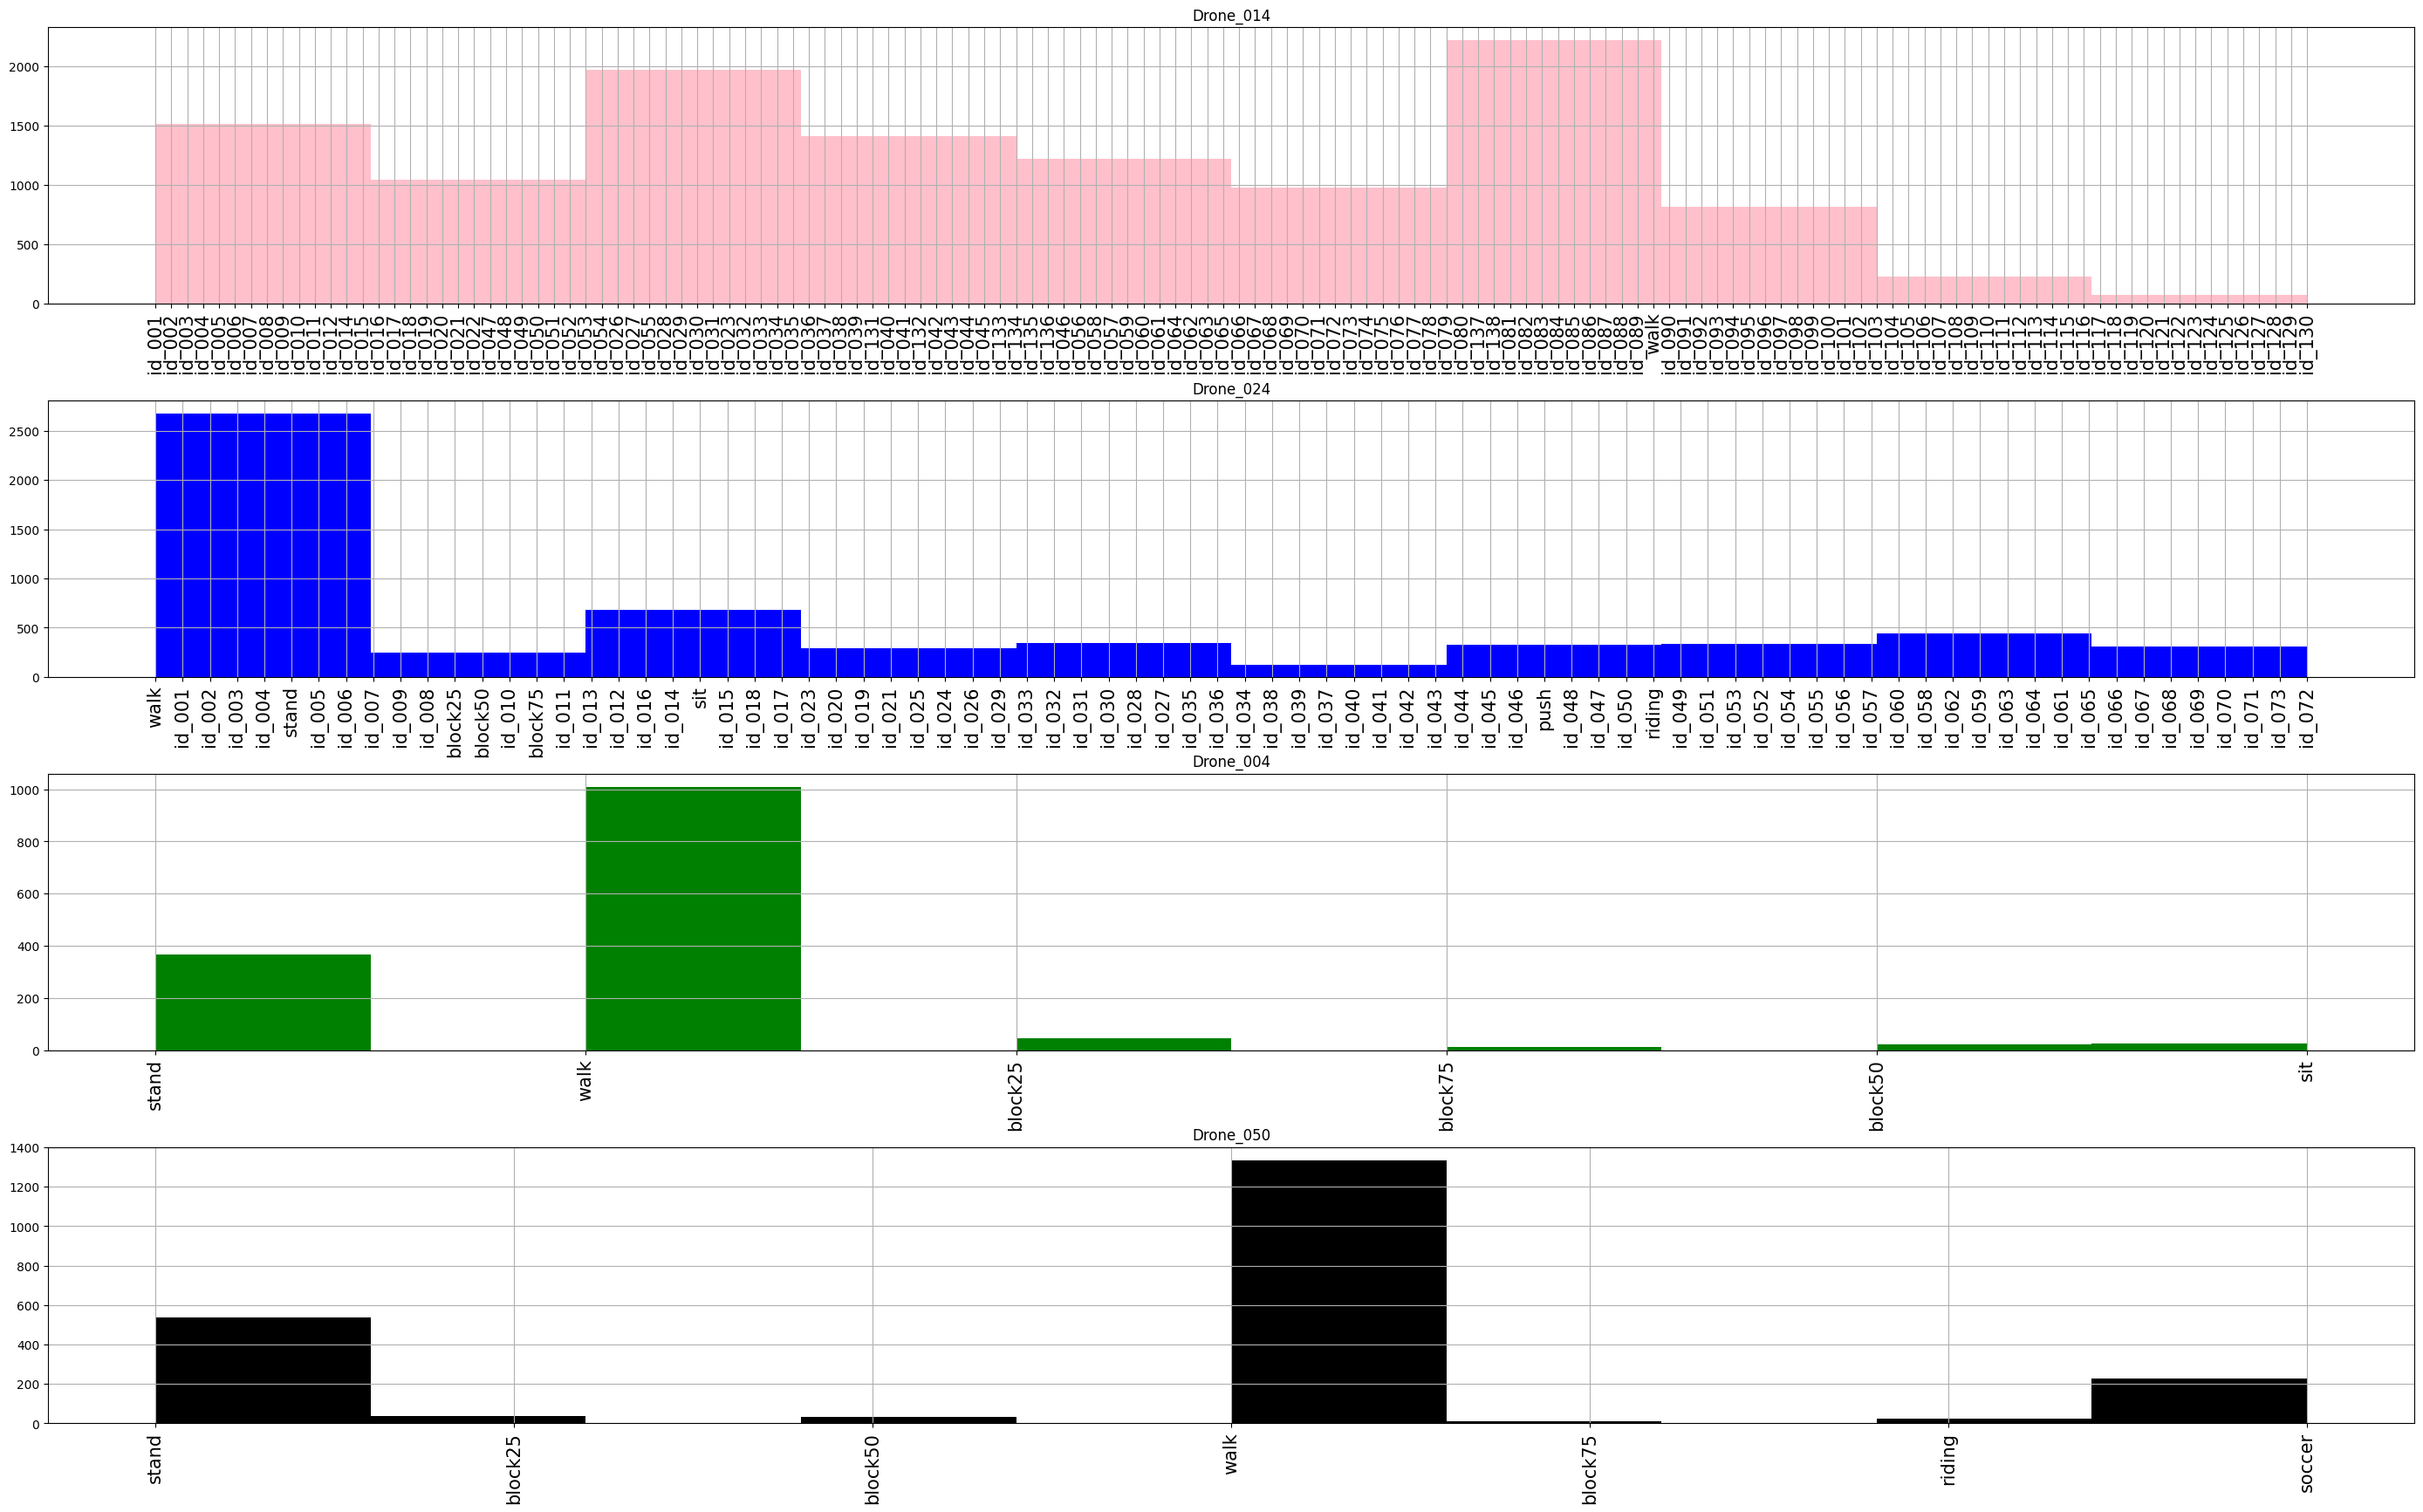

In [ ]:
data, pastas = dataframe(TEST_DATA_DIR)   #chama função para montar dataframe de cada pasta

#plota o histograma
figura = plt.figure(figsize=(35,20))
color = ['pink','blue','green','black']

for c in range(len(pastas)):
  a = figura.add_subplot(4,1,c+1)
  a.title.set_text(pastas[c])
  plt.hist(data[c]['label'], rwidth=1, color = color[c])
  plt.xticks(rotation=90,fontsize=15)
  plt.grid()
  plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)

##Agrupando pastas e selecionando algumas classes

###Juntando dados de treino

In [ ]:
#Montar tabela com todos os dados de treino ou teste
def data(DATA_DIR):
  pastas = os.listdir(DATA_DIR)

  data = []
  count = 0
  for dir in pastas:
      export_path = os.path.join(DATA_DIR, dir, 'vott-csv-export')
      label_file = export_path + '/' + dir + '-export.csv'
      df = pd.read_csv(label_file)
      if count == 0:
        df_inicial = df
      else:
        df_inicial = pd.merge(df_inicial, df, how = 'outer')
      count +=1
  return df_inicial

###Colocando .jpg em cada um dos nomes das imagens

In [ ]:
def renomeia_jpg(dataframe):

  lista_nomeia = list(dataframe.iloc[:,0])
  renomeacao_imagem = []

  for imagem in lista_nomeia:
    if not imagem.endswith('.jpg'):
      imagem = imagem + ".jpg"
    renomeacao_imagem.append(imagem)

  dataframe.drop("image",axis=1,inplace=True)
  dataframe.insert(0,"image", renomeacao_imagem,True)
  return dataframe


In [ ]:
data_train = data(TRAIN_DATA_DIR)           #chama função para montar dataframe de cada pasta
data_train = renomeia_jpg(data_train)       #coloca .jpg no nome de todas as imagens
data_train

,image,xmin,ymin,xmax,ymax,label
0,Drone_023.mp4_t-0.jpg,703.955892,1294.659926,780.702963,1371.424632,walk
1,Drone_023.mp4_t-0.jpg,703.955892,1294.659926,780.702963,1371.424632,id_004
2,Drone_023.mp4_t-0.jpg,632.501723,1215.248162,725.127498,1302.601103,walk
3,Drone_023.mp4_t-0.jpg,632.501723,1215.248162,725.127498,1302.601103,id_003
4,Drone_023.mp4_t-0.jpg,1143.266713,1239.071691,1227.953136,1329.071691,walk
...,...,...,...,...,...,...
31800,Drone_049.mp4_t-97.jpg,2269.987061,97.393196,2302.460018,155.844521,id_140
31801,Drone_049.mp4_t-97.jpg,2438.523926,974.331116,2471.163925,1105.911118,id_142
31802,Drone_049.mp4_t-97.jpg,2498.020264,999.278198,2531.020260,1088.278191,id_143
31803,Drone_049.mp4_t-97.jpg,3624.549805,701.250793,3659.229805,815.490791,id_105


###Filtrando dados de treino

In [ ]:
lista = ['walk', 'stand', 'sit', 'riding']
remover_classes = []
for c in range(len(data_train)):
  if not data_train.iloc[c,5] in lista:
    remover_classes.append(c)

data_train_filtrado = data_train.drop(remover_classes, axis='index')
data_train_filtrado = data_train_filtrado.reset_index(drop=True)
data_train_filtrado

,image,xmin,ymin,xmax,ymax,label
0,Drone_023.mp4_t-0.jpg,703.955892,1294.659926,780.702963,1371.424632,walk
1,Drone_023.mp4_t-0.jpg,632.501723,1215.248162,725.127498,1302.601103,walk
2,Drone_023.mp4_t-0.jpg,1143.266713,1239.071691,1227.953136,1329.071691,walk
3,Drone_023.mp4_t-0.jpg,613.976568,1442.895221,696.016540,1511.718750,walk
4,Drone_023.mp4_t-0.jpg,574.279807,1405.836397,637.794624,1466.718750,walk
...,...,...,...,...,...,...
11612,Drone_031.mp4_t-520.333333.jpg,2207.550228,1985.400055,2268.011290,2054.520099,stand
11613,Drone_031.mp4_t-520.333333.jpg,2273.769403,2034.359967,2345.746910,2106.359967,stand
11614,Drone_031.mp4_t-520.5.jpg,2138.451778,2068.920099,2173.000893,2160.000000,stand
11615,Drone_031.mp4_t-520.5.jpg,2302.560406,2068.920099,2357.263355,2143.800055,stand


##Validação

In [ ]:
#Separar dados de validação (20%) e treino (80%)
x = data_train_filtrado.iloc[:,0]
y = data_train_filtrado.iloc[:,1:]

##define imagens para validação
random.seed(18)
imagens = list(np.unique(x))
imagens_20 = len(imagens)*0.2                              #pega 20% das imagens não repetidas para validação
lista_val = random.sample(imagens,int(imagens_20))         #sorteaia imagens não repetidas para validação
print(lista_val)

#define imagens para treino
lista_treino = []
for element in imagens:
    if element not in lista_val:
        lista_treino.append(element)
print(lista_treino)

['Drone_005.mp4_t-161.333333.jpg', 'Drone_005.mp4_t-143.333333.jpg', 'Drone_023.mp4_t-89.833333.jpg', 'Drone_023.mp4_t-19.5.jpg', 'Drone_005.mp4_t-71.333333.jpg', 'Drone_005.mp4_t-31.166667.jpg', 'Drone_005.mp4_t-17.5.jpg', 'Drone_031.mp4_t-71.5.jpg', 'Drone_023.mp4_t-31.333333.jpg', 'Drone_023.mp4_t-77.666667.jpg', 'Drone_023.mp4_t-33.333333.jpg', 'Drone_005.mp4_t-161.833333.jpg', 'Drone_023.mp4_t-28.jpg', 'Drone_005.mp4_t-54.666667.jpg', 'Drone_023.mp4_t-21.666667.jpg', 'Drone_031.mp4_t-492.jpg', 'Drone_005.mp4_t-40.333333.jpg', 'Drone_005.mp4_t-166.333333.jpg', 'Drone_005.mp4_t-36.666667.jpg', 'Drone_031.mp4_t-497.166667.jpg', 'Drone_031.mp4_t-119.jpg', 'Drone_005.mp4_t-141.666667.jpg', 'Drone_005.mp4_t-64.5.jpg', 'Drone_023.mp4_t-41.jpg', 'Drone_023.mp4_t-93.jpg', 'Drone_031.mp4_t-288.333333.jpg', 'Drone_031.mp4_t-295.833333.jpg', 'Drone_005.mp4_t-159.jpg', 'Drone_031.mp4_t-480.333333.jpg', 'Drone_031.mp4_t-520.5.jpg', 'Drone_031.mp4_t-302.jpg', 'Drone_005.mp4_t-29.333333.jpg', 'Dr

In [ ]:
#transforma nome das imagens em index do dataframe
indice_val = []
indice_train = []
for linha in range(len(x)):
  if data_train_filtrado.iloc[linha,0] in lista_val:
    indice_val.append(linha)
  else:
    indice_train.append(linha)
print(indice_val)
print(indice_train)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 233, 234, 235, 236, 237, 238, 239, 240, 241, 275, 276, 277, 278, 279, 280, 281, 282, 315, 316, 317, 318, 319, 320, 321, 322, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 451, 452, 453, 454, 455, 456, 457, 521, 522, 523, 524, 525, 526, 527, 535, 536, 537, 538, 539, 540, 541, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 811, 812, 813, 814, 815, 816, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 865, 866, 867, 868, 869, 870, 883, 884, 885, 886, 887, 888, 919, 920, 921, 922, 923, 924, 931, 932, 933, 934, 935, 936, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1194

In [ ]:
#Dados de treino
train = data_train_filtrado.drop(indice_val, axis='index')
train = train.reset_index(drop=True)

X_train = train.iloc[:,0]
y_train = train.iloc[:,1:]

train

,image,xmin,ymin,xmax,ymax,label
0,Drone_023.mp4_t-0.jpg,703.955892,1294.659926,780.702963,1371.424632,walk
1,Drone_023.mp4_t-0.jpg,632.501723,1215.248162,725.127498,1302.601103,walk
2,Drone_023.mp4_t-0.jpg,1143.266713,1239.071691,1227.953136,1329.071691,walk
3,Drone_023.mp4_t-0.jpg,613.976568,1442.895221,696.016540,1511.718750,walk
4,Drone_023.mp4_t-0.jpg,574.279807,1405.836397,637.794624,1466.718750,walk
...,...,...,...,...,...,...
9184,Drone_031.mp4_t-519.833333.jpg,2155.726336,1847.159967,2207.550228,1930.680011,stand
9185,Drone_031.mp4_t-519.833333.jpg,2230.582899,1887.480011,2265.132234,1971.000055,stand
9186,Drone_031.mp4_t-520.jpg,2072.232383,1950.839923,2112.539831,2037.239923,stand
9187,Drone_031.mp4_t-520.jpg,2178.759226,1890.359967,2219.066674,1973.880011,stand


In [ ]:
y_train

,xmin,ymin,xmax,ymax,label
0,703.955892,1294.659926,780.702963,1371.424632,walk
1,632.501723,1215.248162,725.127498,1302.601103,walk
2,1143.266713,1239.071691,1227.953136,1329.071691,walk
3,613.976568,1442.895221,696.016540,1511.718750,walk
4,574.279807,1405.836397,637.794624,1466.718750,walk
...,...,...,...,...,...
9184,2155.726336,1847.159967,2207.550228,1930.680011,stand
9185,2230.582899,1887.480011,2265.132234,1971.000055,stand
9186,2072.232383,1950.839923,2112.539831,2037.239923,stand
9187,2178.759226,1890.359967,2219.066674,1973.880011,stand


In [ ]:
#Dados de validação
val = data_train_filtrado.drop(indice_train, axis='index')
val = val.reset_index(drop=True)

X_val = val.iloc[:,0]
y_val = val.iloc[:,1:]

val

,image,xmin,ymin,xmax,ymax,label
0,Drone_023.mp4_t-0.333333.jpg,529.290145,1469.365809,627.208822,1569.954044,walk
1,Drone_023.mp4_t-0.333333.jpg,455.189524,1424.365809,545.168849,1503.777574,walk
2,Drone_023.mp4_t-0.333333.jpg,471.068229,1630.836397,537.229497,1718.189338,walk
3,Drone_023.mp4_t-0.333333.jpg,420.785665,1607.012868,492.239835,1689.071691,walk
4,Drone_023.mp4_t-0.333333.jpg,950.075810,1392.601103,1037.408684,1469.365809,walk
...,...,...,...,...,...,...
2423,Drone_031.mp4_t-520.333333.jpg,2207.550228,1985.400055,2268.011290,2054.520099,stand
2424,Drone_031.mp4_t-520.333333.jpg,2273.769403,2034.359967,2345.746910,2106.359967,stand
2425,Drone_031.mp4_t-520.5.jpg,2138.451778,2068.920099,2173.000893,2160.000000,stand
2426,Drone_031.mp4_t-520.5.jpg,2302.560406,2068.920099,2357.263355,2143.800055,stand


##Juntando dados de teste

In [ ]:
data_test = data(TEST_DATA_DIR)
data_test = renomeia_jpg(data_test)
data_test

,image,xmin,ymin,xmax,ymax,label
0,Drone_014.mp4_t-0.jpg,1717.546520,0.000000,2278.594073,1410.882353,id_001
1,Drone_014.mp4_t-0.jpg,3516.101218,1011.600000,3627.666354,1245.600000,id_002
2,Drone_014.mp4_t-0.jpg,1540.318650,1087.200000,1605.098407,1281.600000,id_003
3,Drone_014.mp4_t-0.jpg,1432.352390,1047.600000,1497.132146,1303.200000,id_004
4,Drone_014.mp4_t-0.jpg,1356.776007,1055.895221,1425.154639,1292.400000,id_005
...,...,...,...,...,...,...
20915,Drone_050.mp4_t-116.166667.jpg,3000.714618,1345.079460,3032.994746,1420.443925,walk
20916,Drone_050.mp4_t-116.jpg,2998.024436,1345.079460,3035.684928,1415.060830,walk
20917,Drone_050.mp4_t-115.833333.jpg,2998.024436,1353.154206,3032.994746,1417.752378,walk
20918,Drone_050.mp4_t-115.666667.jpg,3006.094571,1345.079460,3030.304975,1417.752378,walk


###Filtrando dados de teste

In [ ]:
lista = ['walk', 'stand', 'sit', 'riding']
remover_classes = []
for c in range(len(data_test)):
  if not data_test.iloc[c,5] in lista:
    remover_classes.append(c)

data_test_filtrado = data_test.drop(remover_classes, axis='index')
data_test_filtrado

,image,xmin,ymin,xmax,ymax,label
7496,Drone_014.mp4_t-92.833333.jpg,2353.979980,1031.943604,2455.979980,1432.803589,walk
7498,Drone_014.mp4_t-92.833333.jpg,2176.063965,1082.634033,2273.695068,1400.996338,walk
7500,Drone_014.mp4_t-92.833333.jpg,2988.754395,924.187073,3031.891628,1062.422302,walk
7502,Drone_014.mp4_t-92.833333.jpg,2016.704224,983.228149,2033.178566,1049.125519,walk
7504,Drone_014.mp4_t-92.833333.jpg,2875.814941,925.881409,2911.138443,1025.511803,walk
...,...,...,...,...,...,...
20915,Drone_050.mp4_t-116.166667.jpg,3000.714618,1345.079460,3032.994746,1420.443925,walk
20916,Drone_050.mp4_t-116.jpg,2998.024436,1345.079460,3035.684928,1415.060830,walk
20917,Drone_050.mp4_t-115.833333.jpg,2998.024436,1353.154206,3032.994746,1417.752378,walk
20918,Drone_050.mp4_t-115.666667.jpg,3006.094571,1345.079460,3030.304975,1417.752378,walk


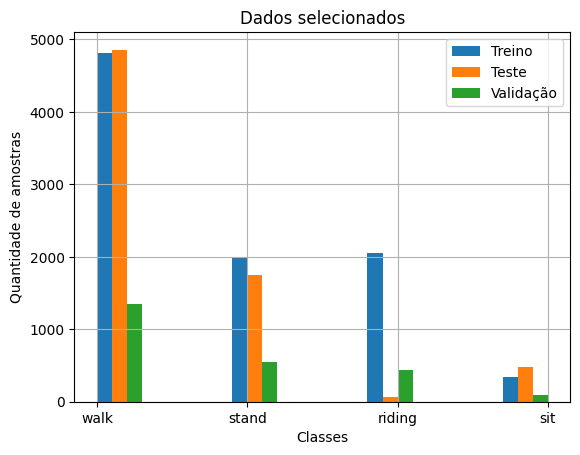

In [ ]:
#plota o histograma
plt.title("Dados selecionados")
plt.hist([y_train['label'],data_test_filtrado['label'],y_val['label']], rwidth=1, label=['Treino', 'Teste', 'Validação' ])
plt.xlabel("Classes")
plt.ylabel("Quantidade de amostras")
plt.legend()
plt.grid()

# Balanceando os dados --> eliminar algumas classes walk

In [ ]:
a = list(X_train)
b = list(y_train['label'])

lista_walk = []
lista_stand = []
lista_riding = []
lista_sit = []

#determina quantas imagens tem as labels walk, stand, riding e sit
for c in range(len(a)):
  if b[c] == 'walk':
    lista_walk.append(a[c])
  elif b[c] == 'stand':
    lista_stand.append(a[c])
  elif b[c] == 'riding':
    lista_riding.append(a[c])
  elif b[c] == 'sit':
    lista_sit.append(a[c])

#printa valores
print(len(np.unique(lista_walk)))
print(len(np.unique(lista_stand)))
print(len(np.unique(lista_riding)))
print(len(np.unique(lista_sit)))

1244
693
549
200


In [ ]:
#seleciona por partes as imagens que somente são rotuladas por walk
exclui_walk = []
exclui_walk1 = []
exclui_walk2 = []

for image_walk in lista_walk:
  if image_walk not in lista_sit:
    exclui_walk.append(image_walk)

for image_walk in exclui_walk:
  if image_walk not in lista_stand:
    exclui_walk1.append(image_walk)

for image_walk in exclui_walk1:
  if image_walk not in lista_riding:
    exclui_walk2.append(image_walk)

print('Só imagens com label walk: {} '.format(len(np.unique(exclui_walk2))))
print('Só imagens com label walk + riding: {} '.format(len(np.unique(exclui_walk1))))
print('Só imagens com label walk + riding + stand: {}'.format(len(np.unique(exclui_walk))))

Só imagens com label walk: 413 
Só imagens com label walk + riding: 698 
Só imagens com label walk + riding + stand: 1078


In [ ]:
#remove as imagens que são rotuladas apenas por walk --> balanceamento
remover_classes = []
for c in range(len(train)):
  if train.iloc[c,0] in exclui_walk2:
    remover_classes.append(c)

train_balanceado = train.drop(remover_classes, axis='index')
train_balanceado = train_balanceado.reset_index(drop=True)
train_balanceado

,image,xmin,ymin,xmax,ymax,label
0,Drone_023.mp4_t-0.jpg,703.955892,1294.659926,780.702963,1371.424632,walk
1,Drone_023.mp4_t-0.jpg,632.501723,1215.248162,725.127498,1302.601103,walk
2,Drone_023.mp4_t-0.jpg,1143.266713,1239.071691,1227.953136,1329.071691,walk
3,Drone_023.mp4_t-0.jpg,613.976568,1442.895221,696.016540,1511.718750,walk
4,Drone_023.mp4_t-0.jpg,574.279807,1405.836397,637.794624,1466.718750,walk
...,...,...,...,...,...,...
8186,Drone_031.mp4_t-519.833333.jpg,2155.726336,1847.159967,2207.550228,1930.680011,stand
8187,Drone_031.mp4_t-519.833333.jpg,2230.582899,1887.480011,2265.132234,1971.000055,stand
8188,Drone_031.mp4_t-520.jpg,2072.232383,1950.839923,2112.539831,2037.239923,stand
8189,Drone_031.mp4_t-520.jpg,2178.759226,1890.359967,2219.066674,1973.880011,stand


In [ ]:
#separa os novos X_train e y_train com base no balanceamento
X_train_balanceado = train_balanceado.iloc[:,0]
y_train_balanceado = train_balanceado.iloc[:,1:]

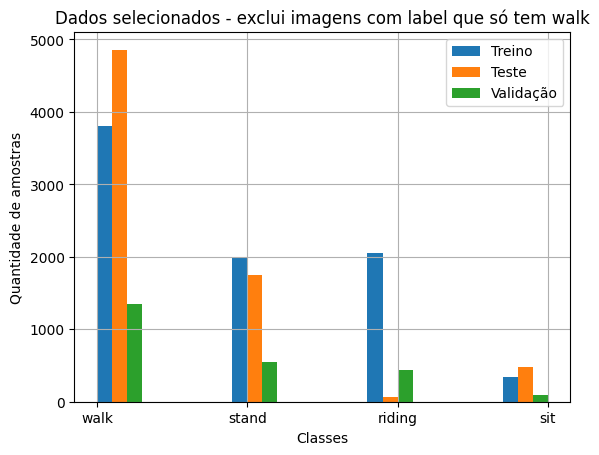

In [ ]:
#plota o histograma
plt.title("Dados selecionados - exclui imagens com label que só tem walk")
plt.hist([y_train_balanceado['label'],data_test_filtrado['label'],y_val['label']], rwidth=1, label=['Treino', 'Teste', 'Validação' ])
plt.xlabel("Classes")
plt.ylabel("Quantidade de amostras")
plt.legend()
plt.grid()

## Salvando os dados

In [ ]:
#Salva todas as imagens selecionadas
def salva_dados_selecionados(dado, DATA_DIR, path_saida):
  imagem_nao_existe = []
  for imagem in tqdm(dado):
    files = DATA_DIR + '/' + imagem[:9] +'/vott-csv-export/' + imagem
    if os.path.isfile(files):                           #verifica se a imagem está dentro da pasta
      shutil.copy(files,path_saida)                     #copia imagem para a nova pasta
      pass
    else:
      imagem_nao_existe.append(imagem)
  return imagem_nao_existe

###Treino

In [ ]:
path_treino = '/content/gdrive/My Drive/IA901_Projeto/Dados_balanceados/train/images'

X_train_balanceado = list(X_train_balanceado)
imagem_nao_existe = salva_dados_selecionados(X_train_balanceado, TRAIN_DATA_DIR, path_treino)
print(imagem_nao_existe)

100%|██████████| 8191/8191 [13:41<00:00,  9.97it/s]

['Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.333333.jpg', 'Drone_005.mp4_t-155.5.jpg', 'Drone_005.mp4_t-155.5.jpg', 'Drone_005.mp4_t-155.5.jpg', 'Drone_005.mp4_t-155.5.jpg', 'Drone_005.mp4_t-155.5.jpg', 'Drone_005.mp4_t-155.5.jpg', 'Drone_005.mp4_t-155.5.jpg', 'Drone_005.mp4_t-155.5.jpg', 'Drone_005.mp4_t-155.5.jpg', 'Drone_005.mp4_t-155.5.jpg', 'Drone_005.mp4_t-155.5.jpg', 

####Monta csv

In [ ]:
#adiciona a coluna "image" no y_train
y_train_balanceado.insert(0,"image", X_train_balanceado,True)
y_train_balanceado

,image,xmin,ymin,xmax,ymax,label
0,Drone_023.mp4_t-0.jpg,703.955892,1294.659926,780.702963,1371.424632,walk
1,Drone_023.mp4_t-0.jpg,632.501723,1215.248162,725.127498,1302.601103,walk
2,Drone_023.mp4_t-0.jpg,1143.266713,1239.071691,1227.953136,1329.071691,walk
3,Drone_023.mp4_t-0.jpg,613.976568,1442.895221,696.016540,1511.718750,walk
4,Drone_023.mp4_t-0.jpg,574.279807,1405.836397,637.794624,1466.718750,walk
...,...,...,...,...,...,...
8186,Drone_031.mp4_t-519.833333.jpg,2155.726336,1847.159967,2207.550228,1930.680011,stand
8187,Drone_031.mp4_t-519.833333.jpg,2230.582899,1887.480011,2265.132234,1971.000055,stand
8188,Drone_031.mp4_t-520.jpg,2072.232383,1950.839923,2112.539831,2037.239923,stand
8189,Drone_031.mp4_t-520.jpg,2178.759226,1890.359967,2219.066674,1973.880011,stand


In [ ]:
#Reorganiza os indices do dataframe
y_train_balanceado = y_train_balanceado.reset_index(drop=True)
y_train_balanceado

,image,xmin,ymin,xmax,ymax,label
0,Drone_023.mp4_t-0.jpg,703.955892,1294.659926,780.702963,1371.424632,walk
1,Drone_023.mp4_t-0.jpg,632.501723,1215.248162,725.127498,1302.601103,walk
2,Drone_023.mp4_t-0.jpg,1143.266713,1239.071691,1227.953136,1329.071691,walk
3,Drone_023.mp4_t-0.jpg,613.976568,1442.895221,696.016540,1511.718750,walk
4,Drone_023.mp4_t-0.jpg,574.279807,1405.836397,637.794624,1466.718750,walk
...,...,...,...,...,...,...
8186,Drone_031.mp4_t-519.833333.jpg,2155.726336,1847.159967,2207.550228,1930.680011,stand
8187,Drone_031.mp4_t-519.833333.jpg,2230.582899,1887.480011,2265.132234,1971.000055,stand
8188,Drone_031.mp4_t-520.jpg,2072.232383,1950.839923,2112.539831,2037.239923,stand
8189,Drone_031.mp4_t-520.jpg,2178.759226,1890.359967,2219.066674,1973.880011,stand


In [ ]:
#antes de montar o dataframe tira imagens que estavam no csv dataframe original
#mas não estavam de fato na pasta dos dados originais
remover_classes = []
for c in range(len(X_train_balanceado)):
  if y_train_balanceado.iloc[c,0] in imagem_nao_existe:
    remover_classes.append(c)

y_train_balanceado.drop(remover_classes, inplace=True)
y_train_balanceado.to_csv('label_train',index=False)
y_train_balanceado

,image,xmin,ymin,xmax,ymax,label
0,Drone_023.mp4_t-0.jpg,703.955892,1294.659926,780.702963,1371.424632,walk
1,Drone_023.mp4_t-0.jpg,632.501723,1215.248162,725.127498,1302.601103,walk
2,Drone_023.mp4_t-0.jpg,1143.266713,1239.071691,1227.953136,1329.071691,walk
3,Drone_023.mp4_t-0.jpg,613.976568,1442.895221,696.016540,1511.718750,walk
4,Drone_023.mp4_t-0.jpg,574.279807,1405.836397,637.794624,1466.718750,walk
...,...,...,...,...,...,...
7939,Drone_031.mp4_t-490.jpg,1870.695364,130.680011,1916.761144,205.559967,riding
7940,Drone_031.mp4_t-490.333333.jpg,1867.816307,185.400000,1913.881868,268.919989,riding
7941,Drone_031.mp4_t-490.5.jpg,1873.574640,211.319989,1922.519257,309.239978,riding
7942,Drone_031.mp4_t-490.666667.jpg,1864.937251,245.880011,1916.761144,335.159967,riding


##Teste

In [ ]:
path_test = '/content/gdrive/My Drive/IA901_Projeto/Dados_balanceados/test/images'

X_teste = list(data_test_filtrado.iloc[:,0])
imagem_nao_existe1 = salva_dados_selecionados(X_teste, TEST_DATA_DIR, path_test)
print(imagem_nao_existe1)

100%|██████████| 7163/7163 [12:54<00:00,  9.25it/s] 

['Drone_050.mp4_t-162.5.jpg', 'Drone_050.mp4_t-162.5.jpg', 'Drone_050.mp4_t-162.5.jpg', 'Drone_050.mp4_t-162.5.jpg', 'Drone_050.mp4_t-162.666667.jpg', 'Drone_050.mp4_t-162.666667.jpg', 'Drone_050.mp4_t-162.666667.jpg', 'Drone_050.mp4_t-162.666667.jpg', 'Drone_050.mp4_t-162.833333.jpg', 'Drone_050.mp4_t-162.833333.jpg', 'Drone_050.mp4_t-162.833333.jpg', 'Drone_050.mp4_t-162.833333.jpg', 'Drone_050.mp4_t-163.jpg', 'Drone_050.mp4_t-163.jpg', 'Drone_050.mp4_t-163.jpg', 'Drone_050.mp4_t-163.jpg', 'Drone_050.mp4_t-163.166667.jpg', 'Drone_050.mp4_t-163.166667.jpg', 'Drone_050.mp4_t-163.166667.jpg', 'Drone_050.mp4_t-163.333333.jpg', 'Drone_050.mp4_t-163.333333.jpg', 'Drone_050.mp4_t-163.333333.jpg', 'Drone_050.mp4_t-163.5.jpg', 'Drone_050.mp4_t-163.5.jpg', 'Drone_050.mp4_t-163.5.jpg', 'Drone_050.mp4_t-163.5.jpg', 'Drone_050.mp4_t-163.666667.jpg', 'Drone_050.mp4_t-163.666667.jpg', 'Drone_050.mp4_t-163.666667.jpg', 'Drone_050.mp4_t-163.666667.jpg', 'Drone_050.mp4_t-163.833333.jpg', 'Drone_050.mp

###Monta csv

In [ ]:
#Reorganiza os indices do dataframe
data_test_filtrado = data_test_filtrado.reset_index(drop=True)
data_test_filtrado

,image,xmin,ymin,xmax,ymax,label
0,Drone_014.mp4_t-92.833333.jpg,2353.979980,1031.943604,2455.979980,1432.803589,walk
1,Drone_014.mp4_t-92.833333.jpg,2176.063965,1082.634033,2273.695068,1400.996338,walk
2,Drone_014.mp4_t-92.833333.jpg,2988.754395,924.187073,3031.891628,1062.422302,walk
3,Drone_014.mp4_t-92.833333.jpg,2016.704224,983.228149,2033.178566,1049.125519,walk
4,Drone_014.mp4_t-92.833333.jpg,2875.814941,925.881409,2911.138443,1025.511803,walk
...,...,...,...,...,...,...
7158,Drone_050.mp4_t-116.166667.jpg,3000.714618,1345.079460,3032.994746,1420.443925,walk
7159,Drone_050.mp4_t-116.jpg,2998.024436,1345.079460,3035.684928,1415.060830,walk
7160,Drone_050.mp4_t-115.833333.jpg,2998.024436,1353.154206,3032.994746,1417.752378,walk
7161,Drone_050.mp4_t-115.666667.jpg,3006.094571,1345.079460,3030.304975,1417.752378,walk


In [ ]:
#antes de montar o dataframe tira imagens que estavam no csv dataframe original
#mas não estavam de fato na pasta dos dados originais
remover_classes = []
for c in range(len(data_test_filtrado)):
  if data_test_filtrado.iloc[c,0] in imagem_nao_existe1:
    remover_classes.append(c)

data_test_filtrado.drop(remover_classes, inplace=True)
data_test_filtrado.to_csv('label_test',index=False)
data_test_filtrado

,image,xmin,ymin,xmax,ymax,label
0,Drone_014.mp4_t-92.833333.jpg,2353.979980,1031.943604,2455.979980,1432.803589,walk
1,Drone_014.mp4_t-92.833333.jpg,2176.063965,1082.634033,2273.695068,1400.996338,walk
2,Drone_014.mp4_t-92.833333.jpg,2988.754395,924.187073,3031.891628,1062.422302,walk
3,Drone_014.mp4_t-92.833333.jpg,2016.704224,983.228149,2033.178566,1049.125519,walk
4,Drone_014.mp4_t-92.833333.jpg,2875.814941,925.881409,2911.138443,1025.511803,walk
...,...,...,...,...,...,...
6266,Drone_050.mp4_t-162.166667.jpg,3092.175049,1310.088826,3132.525312,1388.144942,walk
6267,Drone_050.mp4_t-162.333333.jpg,3474.285714,1413.885430,3536.134454,1524.171856,walk
6268,Drone_050.mp4_t-162.333333.jpg,2137.815126,1526.861768,2186.218487,1642.528020,walk
6269,Drone_050.mp4_t-162.333333.jpg,2172.773109,1524.171856,2218.487395,1623.698630,walk


##Validação

In [ ]:
path_val = '/content/gdrive/My Drive/IA901_Projeto/Dados_balanceados/val/images'

X_val = list(X_val)
imagem_nao_existe2 = salva_dados_selecionados(X_val, TRAIN_DATA_DIR, path_val)
print(imagem_nao_existe2)

100%|██████████| 2428/2428 [04:01<00:00, 10.06it/s]

['Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.166667.jpg', 'Drone_005.mp4_t-155.833333.jpg', 'Drone_005.mp4_t-155.833333.jpg', 'Drone_005.mp4_t-155.833333.jpg', 'Drone_005.mp4_t-155.833333.jpg', 'Drone_005.mp4_t-155.833333.jpg', 'Drone_005.mp4_t-155.833333.jpg', 'Drone_005.mp4_t-155.833333.jpg', 'Drone_005.mp4_t-155.833333.jpg', 'Drone_005.mp4_t-155.833333.jpg', 'Drone_005.mp

###Monta csv

In [ ]:
#adiciona a coluna "image" no y_val
y_val.insert(0,"image", X_val,True)
y_val

,image,xmin,ymin,xmax,ymax,label
0,Drone_023.mp4_t-0.333333.jpg,529.290145,1469.365809,627.208822,1569.954044,walk
1,Drone_023.mp4_t-0.333333.jpg,455.189524,1424.365809,545.168849,1503.777574,walk
2,Drone_023.mp4_t-0.333333.jpg,471.068229,1630.836397,537.229497,1718.189338,walk
3,Drone_023.mp4_t-0.333333.jpg,420.785665,1607.012868,492.239835,1689.071691,walk
4,Drone_023.mp4_t-0.333333.jpg,950.075810,1392.601103,1037.408684,1469.365809,walk
...,...,...,...,...,...,...
2423,Drone_031.mp4_t-520.333333.jpg,2207.550228,1985.400055,2268.011290,2054.520099,stand
2424,Drone_031.mp4_t-520.333333.jpg,2273.769403,2034.359967,2345.746910,2106.359967,stand
2425,Drone_031.mp4_t-520.5.jpg,2138.451778,2068.920099,2173.000893,2160.000000,stand
2426,Drone_031.mp4_t-520.5.jpg,2302.560406,2068.920099,2357.263355,2143.800055,stand


In [ ]:
#Reorganiza os indices do dataframe
y_val = y_val.reset_index(drop=True)
y_val

,image,xmin,ymin,xmax,ymax,label
0,Drone_023.mp4_t-0.333333.jpg,529.290145,1469.365809,627.208822,1569.954044,walk
1,Drone_023.mp4_t-0.333333.jpg,455.189524,1424.365809,545.168849,1503.777574,walk
2,Drone_023.mp4_t-0.333333.jpg,471.068229,1630.836397,537.229497,1718.189338,walk
3,Drone_023.mp4_t-0.333333.jpg,420.785665,1607.012868,492.239835,1689.071691,walk
4,Drone_023.mp4_t-0.333333.jpg,950.075810,1392.601103,1037.408684,1469.365809,walk
...,...,...,...,...,...,...
2423,Drone_031.mp4_t-520.333333.jpg,2207.550228,1985.400055,2268.011290,2054.520099,stand
2424,Drone_031.mp4_t-520.333333.jpg,2273.769403,2034.359967,2345.746910,2106.359967,stand
2425,Drone_031.mp4_t-520.5.jpg,2138.451778,2068.920099,2173.000893,2160.000000,stand
2426,Drone_031.mp4_t-520.5.jpg,2302.560406,2068.920099,2357.263355,2143.800055,stand


In [ ]:
#antes de montar o dataframe tira imagens que estavam no csv dataframe original
#mas não estavam de fato na pasta dos dados originais
remover_classes = []
for c in range(len(X_val)):
  if y_val.iloc[c,0] in imagem_nao_existe2:
    remover_classes.append(c)

y_val.drop(remover_classes, inplace=True)
y_val.to_csv('label_val',index=False)
y_val

,image,xmin,ymin,xmax,ymax,label
0,Drone_023.mp4_t-0.333333.jpg,529.290145,1469.365809,627.208822,1569.954044,walk
1,Drone_023.mp4_t-0.333333.jpg,455.189524,1424.365809,545.168849,1503.777574,walk
2,Drone_023.mp4_t-0.333333.jpg,471.068229,1630.836397,537.229497,1718.189338,walk
3,Drone_023.mp4_t-0.333333.jpg,420.785665,1607.012868,492.239835,1689.071691,walk
4,Drone_023.mp4_t-0.333333.jpg,950.075810,1392.601103,1037.408684,1469.365809,walk
...,...,...,...,...,...,...
2364,Drone_031.mp4_t-481.333333.jpg,2239.220288,1708.920099,2296.802293,1789.559967,walk
2365,Drone_031.mp4_t-481.833333.jpg,2224.824786,1801.080011,2305.439682,1887.480011,walk
2366,Drone_031.mp4_t-482.833333.jpg,2244.978400,1994.039923,2322.714240,2112.120099,walk
2367,Drone_031.mp4_t-489.166667.jpg,1860.618557,1.080011,1919.640200,72.000000,riding


##Quantidade de imagens

In [ ]:
#Treino
qtd_treino = os.listdir(path_treino)
qtd_teste = os.listdir(path_test)
qtd_val = os.listdir(path_val)

print("Treino = ", len(qtd_treino))
print("Teste = ", len(qtd_teste))
print("Val = ", len(qtd_val))

Treino =  1070
Teste =  1266
Val =  350


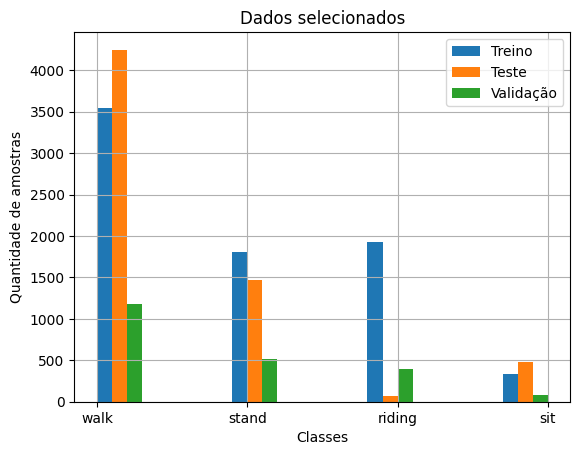

In [ ]:
#plota o histograma --> quantidade de amostras que de fato serão utilizadas
plt.title("Dados selecionados")
plt.hist([y_train_balanceado['label'],data_test_filtrado['label'],y_val['label']], rwidth=1, label=['Treino', 'Teste', 'Validação' ])
plt.xlabel("Classes")
plt.ylabel("Quantidade de amostras")
plt.legend()
plt.grid()